## Importing libraries and modules

In [0]:
from keras import backend as K
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import time
import matplotlib.pyplot as plt
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,SeparableConv2D,Conv2D
from keras.layers import Activation, Flatten, Dense, Dropout,Concatenate,GlobalAveragePooling2D,Input
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Lambda

## Importing Cifar10 data


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

##  Ploting each class from cifar10 dataset


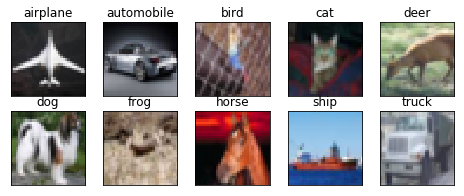

In [23]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## Function for ploting model history


In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

## Function for model accuracy

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
# convert class labels to binary class labels
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

## Space_To_Depth Function

In [0]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

## Main Model

In [29]:
from keras.models import Model

# Define the model
input = Input(shape=(32,32,3))
#===============================================================================
# Layer 1 SepConv2D 5x5
L1 = SeparableConv2D(4,(5,5), padding='same',name ='SepConv_1')(input)
L1 = BatchNormalization(name='BN_1')(L1)
L1 = Activation ('relu', name = 'Relu_1')(L1)

# Skip L1 => become input of layers 4,5,7,9,10,12
#===============================================================================

# Layer 2 Conv2D 5x5
L2 = Conv2D(4,(5,5), padding = 'same', name = 'Conv2D_2')(L1)
L2 = BatchNormalization(name='BN_2')(L2)
L2 = Activation ('relu', name = 'Relu_2')(L2)

# Skip L2 => become input of layers 12,13
#===============================================================================

# Layer 3 Conv2D 5x5
L3 = Conv2D(4,(5,5), padding = 'same', name = 'Conv2D_3')(L2)
L3 = BatchNormalization(name='BN_3')(L3)
L3 = Activation ('relu', name = 'Relu_3')(L3)
# L3 = L3 + L1
L3 = Concatenate(name ='Concat_L3')([L3,L1])
# Skip L3 => become input of layers 8,9,13,14
#===============================================================================

# Layer 4 SepConv2D 5x5
L4 = SeparableConv2D(4,(5,5), padding='same',name ='SepConv_4')(L3)
L4 = BatchNormalization(name='BN_4')(L4)
L4 = Activation ('relu', name = 'Relu_4')(L4)
#L4 = L4 + L1
L4 = Concatenate(name = 'Concat_L4')([L4,L1]) 
# Skip L4 => become input of layers 7,8,9,10,14,15
#===============================================================================

# Layer 5 MaxPool 
L5 = MaxPooling2D(pool_size=(2,2), name = 'MaxPool_5')(L4)
#===============================================================================

# Layer 6 SepConv2D 3x3
L6 = SeparableConv2D(8,(3,3), padding='same',name ='SepConv_6')(L5)
L6 = BatchNormalization(name='BN_6')(L6)
L6 = Activation ('relu', name = 'Relu_6')(L6)
#L6 = L6 + L1 + L4
Concat_L1_L4 = Concatenate(axis =-1)([L1,L4])  
skip_con = Concat_L1_L4
skip_con = Lambda(space_to_depth_x2)(skip_con)
L6 = Concatenate(name = 'Concat_L6')([L6,skip_con])
# Skip 6 => become input of layers 8,9,13,14
#===============================================================================

# Layer 7 Conv2D 5x5
L7 = Conv2D(8,(5,5), padding = 'same', name = 'Conv2D_7')(L6)
L7 = BatchNormalization(name='BN_7')(L7)
L7 = Activation ('relu', name = 'Relu_7')(L7)
#L7 = L7 +L3 + L4 + L6
Concat_L3_L4 = Concatenate(axis =-1)([L3,L4])
skip_con = Concat_L3_L4
skip_con = Lambda(space_to_depth_x2)(skip_con)
Concat_L3_L4_L6 = Concatenate(axis =-1)([skip_con,L6])
L7 = Concatenate(name = 'Concat_L7')([L7,Concat_L3_L4_L6])
# Skip 7 => become input of layers 9,11
#===============================================================================

# Layer 8 SepConv2D 3x3
L8 = SeparableConv2D(8,(3,3), padding='same',name ='SepConv_8')(L7)
L8 = BatchNormalization(name='BN_8')(L8)
L8 = Activation ('relu', name = 'Relu_8')(L8)
#L8 = L8 + L1 + L3 + L4 + L6 + L7
Concat_L1_L3_L4 = Concatenate(axis =-1)([L1,L3,L4])
skip_con = Concat_L1_L3_L4
skip_con = Lambda(space_to_depth_x2)(skip_con)
L8 = Concatenate(name = 'Concat_L8')([L8,skip_con,L6,L7])
# Skip 8 => become input of layers 10,12,14,15
#===============================================================================

# Layer 9 SepConv2D 5x5
L9 = SeparableConv2D(8,(5,5), padding='same',name ='SepConv_9')(L8)
L9 = BatchNormalization(name='BN_9')(L9)
L9 = Activation ('relu', name = 'Relu_9')(L9)
#L9 = L9 + L1 + L4 + L8
Concat_L1_L4 = Concatenate(axis =-1)([L1,L4])
skip_con = Concat_L1_L4
skip_con = Lambda(space_to_depth_x2)(skip_con)
L9 = Concatenate(name = 'Concat_L9')([L9,skip_con,L8])
#===============================================================================

# Layer 10 MaxPool 
L10 = MaxPooling2D(pool_size=(2,2), name = 'MaxPool_10')(L9)
#L10 = L10 + L7
skip_con = L7
skip_con = Lambda(space_to_depth_x2)(skip_con)
L10 = Concatenate(axis =-1)([L10,skip_con])
#===============================================================================

# Layer 11 Conv2D 5x5
L11 = Conv2D(12,(5,5), padding = 'same', name = 'Conv2D_11')(L10)
L11 = BatchNormalization(name='BN_11')(L11)
L11 = Activation ('relu', name = 'Relu_11')(L11)
#L11 = L11 + L1 + L2 + L8
Concat_L1_L2 = Concatenate(axis =-1)([L1,L2])
skip_con = Concat_L1_L2
skip_con = Lambda(space_to_depth_x2)(skip_con)
Concat_L8 = Concatenate(axis =-1)([L8,skip_con])
skip_con = Concat_L8
skip_con = Lambda(space_to_depth_x2)(skip_con)
L11 = Concatenate(name = 'Concat_L11')([L11,skip_con])
# Skip 11 => become input of layers 12
#===============================================================================

# Layer 12 SepConv2D 5x5
L12 = SeparableConv2D(12,(5,5), padding='same',name ='SepConv_12')(L11)
L12 = BatchNormalization(name='BN_12')(L12)
L12 = Activation ('relu', name = 'Relu_12')(L12)
#L12 = L12 + L2 + L3 + L6 + L11
Concat_L2_L3 = Concatenate(axis =-1)([L2,L3])
skip_con = Concat_L2_L3
skip_con = Lambda(space_to_depth_x2)(skip_con)
Concat_L6 = Concatenate(axis =-1)([L6,skip_con])
skip_con = Concat_L6
skip_con = Lambda(space_to_depth_x2)(skip_con)
Concat_L11 = Concatenate(axis =-1)([L11,skip_con])
L12 = Concatenate(name = 'Concat_L12')([L12,Concat_L11])
# Skip 12 => become input of layers 14,15
#===============================================================================

# Layer 13 Conv2D 3x3
L13 = Conv2D(12,(3,3), padding='same',name ='SepConv_13')(L12)
L13 = BatchNormalization(name='BN_13')(L13)
L13 = Activation ('relu', name = 'Relu_13')(L13)
#L13 = L13 + L3 + L4 + L6 + L8 + L12
Concat_L3_L4 = Concatenate(axis =-1)([L3,L4])
skip_con = Concat_L3_L4
skip_con1 = Lambda(space_to_depth_x2)(skip_con)
Concat_skip_1_skip2 = Concatenate(axis =-1)([skip_con1,L6,L8])
skip_con = Concat_skip_1_skip2
skip_con = Lambda(space_to_depth_x2)(skip_con)
L13 = Concatenate(name = 'Concat_L13')([L13,L12,skip_con])
#===============================================================================

# Layer 14 SepConv2D 5x5
L14 = SeparableConv2D(16,(5,5), padding='same',name ='SepConv_14')(L13)
L14 = BatchNormalization(name='BN_14')(L14)
L14 = Activation ('relu', name = 'Relu_14')(L14)
#===============================================================================

# Layer 15
#L14 = L14 + L4 + L8 + L12
skip_con = L4
skip_con = Lambda(space_to_depth_x2)(skip_con)
Concat_L8_Skip = Concatenate(axis =-1)([skip_con,L8])
skip_con = Concat_L8_Skip
skip_con = Lambda(space_to_depth_x2)(skip_con)
L14 = Concatenate(name = 'Concat_L14')([L14,L12,skip_con])
output1 = Conv2D(10,(8,8), activation='relu',padding='same', name='output1')(L14) 
output2 = Conv2D(10,(1,1),padding='same', name='output2')(output1)
output3 = GlobalAveragePooling2D()(output2)
output = Activation('softmax')(output3)
#===============================================================================

model = Model(inputs=[input], outputs=[output])
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
SepConv_1 (SeparableConv2D)     (None, 32, 32, 4)    91          input_5[0][0]                    
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 32, 32, 4)    16          SepConv_1[0][0]                  
__________________________________________________________________________________________________
Relu_1 (Activation)             (None, 32, 32, 4)    0           BN_1[0][0]                       
__________________________________________________________________________________________________
Conv2D_2 (

Epoch 1/100
391/390 [==============================] - 154s 394ms/step - loss: 2.1637 - acc: 0.1741 - val_loss: 2.2914 - val_acc: 0.1457
Epoch 2/100
391/390 [==============================] - 144s 368ms/step - loss: 1.9479 - acc: 0.2158 - val_loss: 1.9055 - val_acc: 0.2132
Epoch 3/100
391/390 [==============================] - 144s 368ms/step - loss: 1.8671 - acc: 0.2309 - val_loss: 1.9284 - val_acc: 0.2155
Epoch 4/100
391/390 [==============================] - 144s 368ms/step - loss: 1.8127 - acc: 0.2462 - val_loss: 1.8368 - val_acc: 0.2290
Epoch 5/100
391/390 [==============================] - 144s 368ms/step - loss: 1.7655 - acc: 0.2598 - val_loss: 1.7962 - val_acc: 0.2613
Epoch 6/100
391/390 [==============================] - 144s 368ms/step - loss: 1.7280 - acc: 0.2741 - val_loss: 2.3026 - val_acc: 0.2487
Epoch 7/100
391/390 [==============================] - 144s 368ms/step - loss: 1.6965 - acc: 0.2827 - val_loss: 1.9172 - val_acc: 0.2177
Epoch 8/100
391/390 [====================

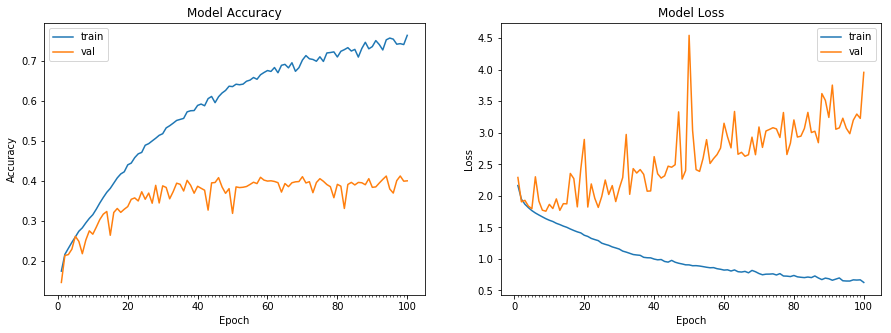

Accuracy on test data is: 40.03


In [30]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(zoom_range=0.0,horizontal_flip=False)
# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 256),
                                 steps_per_epoch = train_features.shape[0]/128, epochs = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))